In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout

from google.colab import files

!pip3 install -q torch torchvision
!pip3 install -q Pillow==9.0.0

In [3]:
# Download train data
!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
!unzip -q "train.zip"

train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
!unzip -q "test.zip"

test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

--2022-04-16 14:59:45--  https://storage.googleapis.com/dlcourse_ai/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.253.119.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562348083 (536M) [application/zip]
Saving to: ‘train.zip.1’

train.zip.1         100%[===================>] 536.30M   181MB/s    in 3.0s    

2022-04-16 14:59:49 (181 MB/s) - ‘train.zip.1’ saved [562348083/562348083]

replace train_kaggle/pets_169.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Number of files in the train folder 4603
--2022-04-16 15:03:12--  https://storage.googleapis.com/dlcourse_ai/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 64.233.191.128, 173.194.74.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting respon

In [4]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!

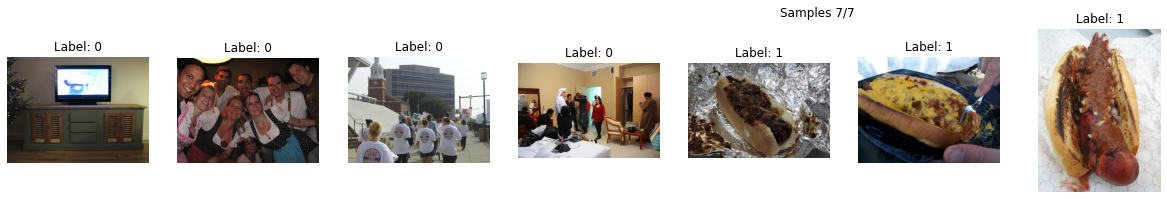

In [5]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        
        # TODO: Your code here!
        self.root_dir = folder
        self.data = os.listdir(folder)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):        
        # TODO Implement getting item by index
        # Hint: os.path.join is helpful!
        img_id = self.data[index]
        img_full_name = os.path.join(self.root_dir, img_id)
        img = Image.open(img_full_name)
        if 'frankfurter' in img_id or 'chili-dog' in img_id or 'hotdog' in img_id:
            y = 1
        else:
            y = 0
            
        if self.transform:
            img = self.transform(img)
        return img, y, img_id

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

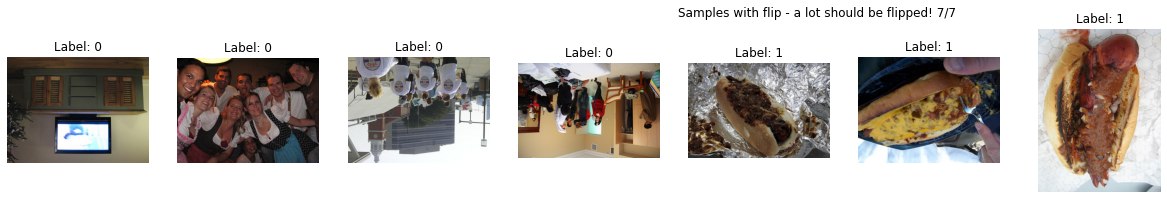

In [6]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

# Создаем DataSet для тренировок

In [7]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [8]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[val_split:], indices[:val_split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Наши обычные функции для тренировок

In [9]:
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    correct_samples = 0
    total_samples = 0
    
    for (x, y,_) in loader:
        x_gpu, y_gpu = x.to(device), y.to(device)
        prediction = model(x_gpu)
        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
        
    accuracy = float(correct_samples) / total_samples
    
    return accuracy

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

## Использование заранее натренированной сети (pretrained network)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

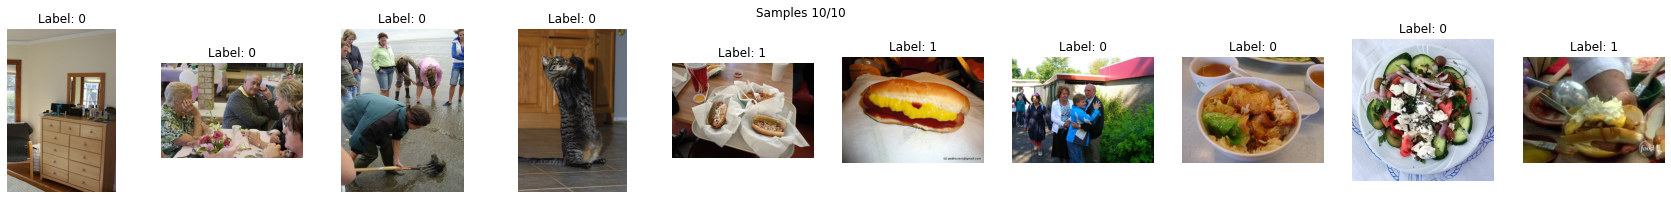

In [10]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # TODO: Process it to return dict of class index to name
    return { int(k): v[-1] for k, v in classes.items()}
    
model = models.resnet18(pretrained=True)
indices = np.random.choice(np.arange(len(train_dataset)), 10, replace=False)
imagenet_classes = load_imagenet_classes()

visualize_samples(orig_dataset, indices, "Samples")

# TODO: Run this model on 10 random images of your dataset and visualize what it predicts

In [11]:
for ind in indices:
    img = train_dataset[ind][0].unsqueeze(0)
    label = train_dataset[ind][1]
    model.eval()
    prediction = model(img)
    predicted_class = imagenet_classes[int(torch.argmax(prediction))]
    print('Label: {0} Predicted class: {1}'.format(label, predicted_class))

Label: 0 Predicted class: file
Label: 0 Predicted class: grocery_store
Label: 0 Predicted class: coho
Label: 0 Predicted class: tabby
Label: 1 Predicted class: hotdog
Label: 1 Predicted class: hotdog
Label: 0 Predicted class: mortarboard
Label: 0 Predicted class: guacamole
Label: 0 Predicted class: cucumber
Label: 1 Predicted class: American_lobster


а если еще разок)))

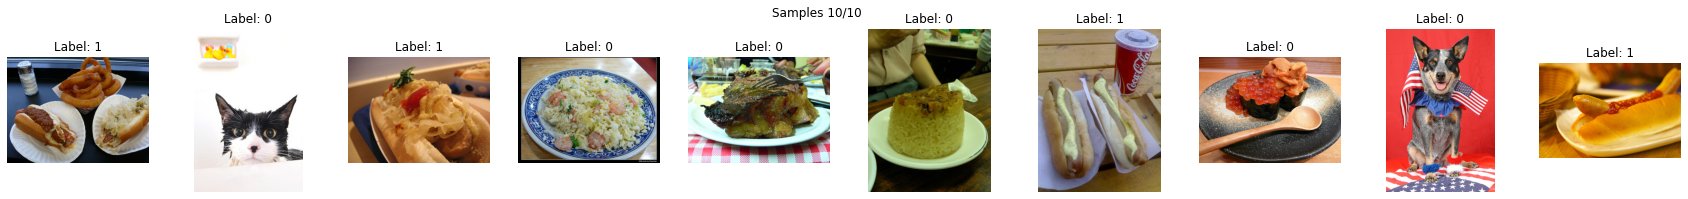

In [12]:
model = models.resnet18(pretrained=True)
indices = np.random.choice(np.arange(len(train_dataset)), 10, replace=False)
imagenet_classes = load_imagenet_classes()

visualize_samples(orig_dataset, indices, "Samples")

In [13]:
for ind in indices:
    img = train_dataset[ind][0].unsqueeze(0)
    label = train_dataset[ind][1]
    model.eval()
    prediction = model(img)
    predicted_class = imagenet_classes[int(torch.argmax(prediction))]
    print('Label: {0} Predicted class: {1}'.format(label, predicted_class))

Label: 1 Predicted class: hotdog
Label: 0 Predicted class: ping-pong_ball
Label: 1 Predicted class: hotdog
Label: 0 Predicted class: mashed_potato
Label: 0 Predicted class: plate
Label: 0 Predicted class: burrito
Label: 1 Predicted class: hotdog
Label: 0 Predicted class: guacamole
Label: 0 Predicted class: kelpie
Label: 1 Predicted class: hotdog


## Перенос обучения (transfer learning) - тренировать только последний слой

In [15]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
for param in model.parameters():
    param.requires_grad = False

resnet_output = model.fc.in_features
model.fc = nn.Linear(resnet_output, 2)
model = model.to(device)
parameters = model.fc.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

Average loss: 0.359569, Train accuracy: 0.834917, Val accuracy: 0.919565
Average loss: 0.206895, Train accuracy: 0.923432, Val accuracy: 0.943478


## Перенос обучения (transfer learning) - тренировать всю модель

In [16]:
import torch.nn as nn
import torch.optim as optim

# TODO: Add a new output layer and train the whole model
model = models.resnet18(pretrained=True)
resnet_output = model.fc.in_features
model.fc = nn.Linear(resnet_output, 2)
model = model.to(device)
parameters = model.parameters()

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.324613, Train accuracy: 0.851751, Val accuracy: 0.939130
Average loss: 0.154256, Train accuracy: 0.945968, Val accuracy: 0.951087
Average loss: 0.095936, Train accuracy: 0.966332, Val accuracy: 0.953261
Average loss: 0.074267, Train accuracy: 0.976649, Val accuracy: 0.955435
Average loss: 0.058092, Train accuracy: 0.983166, Val accuracy: 0.960870


## Перенос обучения (transfer learning) - разные скорости обучения для разных слоев

In [17]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Add a new output layer and train the whole model
# Train new layer with learning speed 0.001 and old layers with 0.0001
resnet_output = model.fc.in_features
model.fc = nn.Linear(resnet_output, 2)
last_layer_params = model.fc.parameters()
model = model.to(device)

optimizer = optim.SGD([
    {'params': [param for name, param in model.state_dict().items()
               if not 'fc' in name]},
    {'params': last_layer_params, 'lr': 1e-3, 'momentum': 0.9}],
    lr=1e-4, momentum=0.9
)
loss = nn.CrossEntropyLoss()
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.348683, Train accuracy: 0.844692, Val accuracy: 0.913043
Average loss: 0.203715, Train accuracy: 0.925876, Val accuracy: 0.929348
Average loss: 0.187319, Train accuracy: 0.931849, Val accuracy: 0.929348
Average loss: 0.166926, Train accuracy: 0.937822, Val accuracy: 0.941304
Average loss: 0.171684, Train accuracy: 0.934293, Val accuracy: 0.939130


## Визуализируем метрики и ошибки модели

Попробуем посмотреть, где модель ошибается - визуализируем ложные срабатывания (false positives) и ложноотрицательные срабатывания (false negatives).

Для этого мы прогоним модель через все примеры и сравним ее с истинными метками (ground truth).

In [18]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    predictions = []
    ground_truth = []
    subset_sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=subset_sampler)
    
    for (x,y,_) in loader:
        x_gpu, y_gpu = x.to(device), y.to(device)
        prediction = torch.argmax(model(x_gpu), 1)
        
        predictions.extend(prediction.tolist())
        ground_truth.extend(y_gpu.tolist())
        
    return np.array(predictions), np.array(ground_truth)

predictions, gt = evaluate_model(model, train_dataset, val_indices)

И теперь можно визуализировать false positives и false negatives.

In [23]:
import sklearn.metrics as metrics
def binary_classification_metrics(predictions, ground_truth):
    # TODO: Implement this function!
    # We did this already it in the assignment1
    assert len(predictions) == len(ground_truth)
    
    tp = np.sum((predictions==ground_truth) & (predictions==True))
    fp = np.sum((predictions!=ground_truth) & (predictions==True))
    fn = np.sum((predictions!=ground_truth) & (predictions==False))
    
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0

    print("tp = %4.3f, fp = %4.3f, fn = %4.3f" % (tp, fp, fn))
    
    return precision, recall, f1

precision, recall, f1 = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

tp = 276.000, fp = 41.000, fn = 15.000
F1: 0.908, P: 0.871, R: 0.948


In [19]:
def get_fp_and_fn_samples(predictions, gt, val_indices):
  false_positive_indices = []
  false_negative_indices = []

  for ind, gts in enumerate(gt):
      if not gts and gts != predictions[ind]:
          false_positive_indices.append(val_indices[ind])
      if gts and gts != predictions[ind]:
          false_negative_indices.append(val_indices[ind])
  return false_positive_indices, false_negative_indices

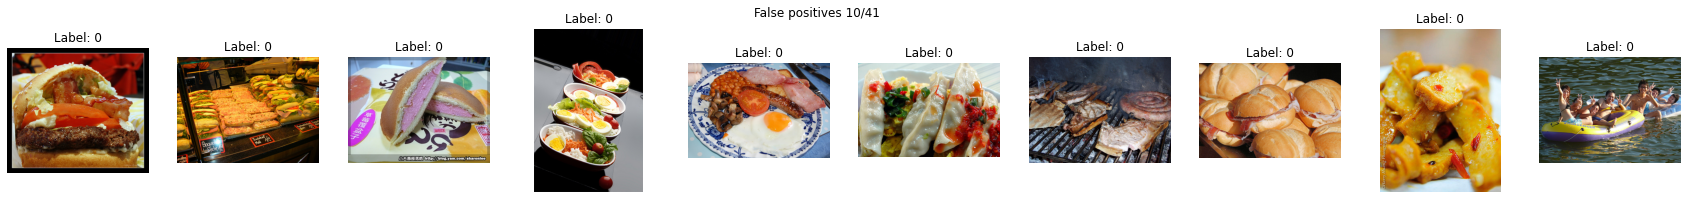

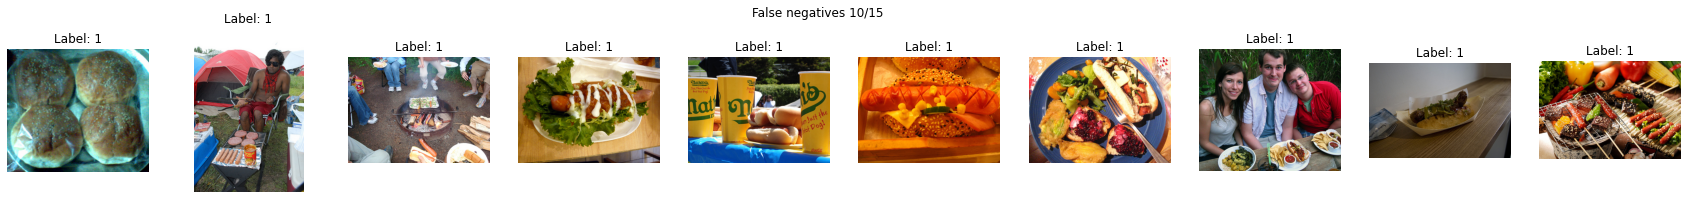

In [20]:
false_positive_indices, false_negative_indices = \
                       get_fp_and_fn_samples(predictions, gt, val_indices)

visualize_samples(orig_dataset, false_positive_indices, "False positives")

visualize_samples(orig_dataset, false_negative_indices, "False negatives")

# Что будет в конце вы уже поняли (АГА, поняли!)

Наша цель - довести F1 score на validation set до значения, большего 0.93.

In [24]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
resnet_output = model.fc.in_features
model.fc = nn.Linear(resnet_output, 2)
last_layer_params = model.fc.parameters()
model = model.to(device)

# Train new layer with learning speed 0.001 and old layers with 0.0001
optimizer = optim.Adam([
    {'params': [param for name, param in model.state_dict().items()
               if not 'fc' in name]},
    {'params': last_layer_params, 'lr': 1e-3}],
    lr=1e-4, weight_decay=1e-4
)
loss = nn.CrossEntropyLoss()
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 9)

Average loss: 0.430272, Train accuracy: 0.800706, Val accuracy: 0.905435
Average loss: 0.222053, Train accuracy: 0.913929, Val accuracy: 0.926087
Average loss: 0.183767, Train accuracy: 0.931578, Val accuracy: 0.940217
Average loss: 0.168789, Train accuracy: 0.934021, Val accuracy: 0.939130
Average loss: 0.159869, Train accuracy: 0.939995, Val accuracy: 0.940217
Average loss: 0.151454, Train accuracy: 0.941895, Val accuracy: 0.936957
Average loss: 0.156834, Train accuracy: 0.940809, Val accuracy: 0.948913
Average loss: 0.139593, Train accuracy: 0.946511, Val accuracy: 0.940217
Average loss: 0.132857, Train accuracy: 0.950312, Val accuracy: 0.948913


In [25]:
best_model = model

In [26]:
# Let's check how it performs on validation set!
predictions, ground_truth = evaluate_model(best_model, train_dataset, val_indices)
precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (precision, recall, f1))

tp = 263.000, fp = 19.000, fn = 28.000
F1: 0.933, P: 0.904, R: 0.918


In [27]:
torch.cuda.empty_cache()

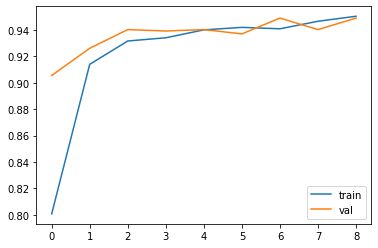

In [28]:
# TODO: Visualize training curve for the best model
plt.plot(train_history)
plt.plot(val_history)
plt.gca().legend(('train', 'val'))
plt.show();

## Визуализируйте ошибки лучшей модели

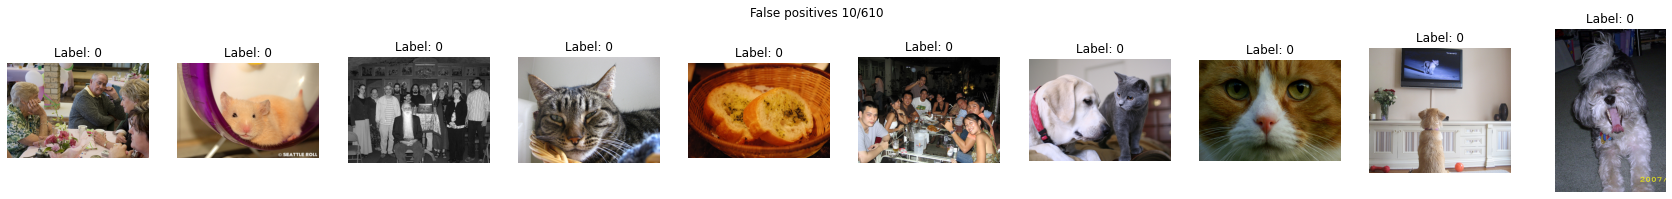

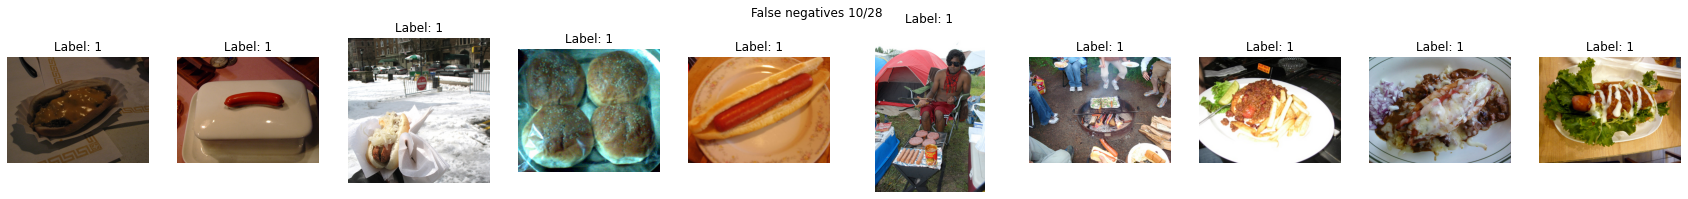

In [29]:
false_positive_indices = np.array(val_indices)[(predictions==0) & (gt==0)]
visualize_samples(orig_dataset, false_positive_indices, "False positives")

false_negatives_indices = np.array(val_indices)[(predictions==0) & (gt==1)]
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")